# Hand Gestures Classification

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statistics as st
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix


from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import cv2
import mediapipe as mp






## Data Loading

In [3]:
df = pd.read_csv(r'Data/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


## Data Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

Q: Are there any missing values?

In [5]:
df.columns[df.isnull().sum()>0]

Index([], dtype='object')

#### How many instances of every label are there in the data?

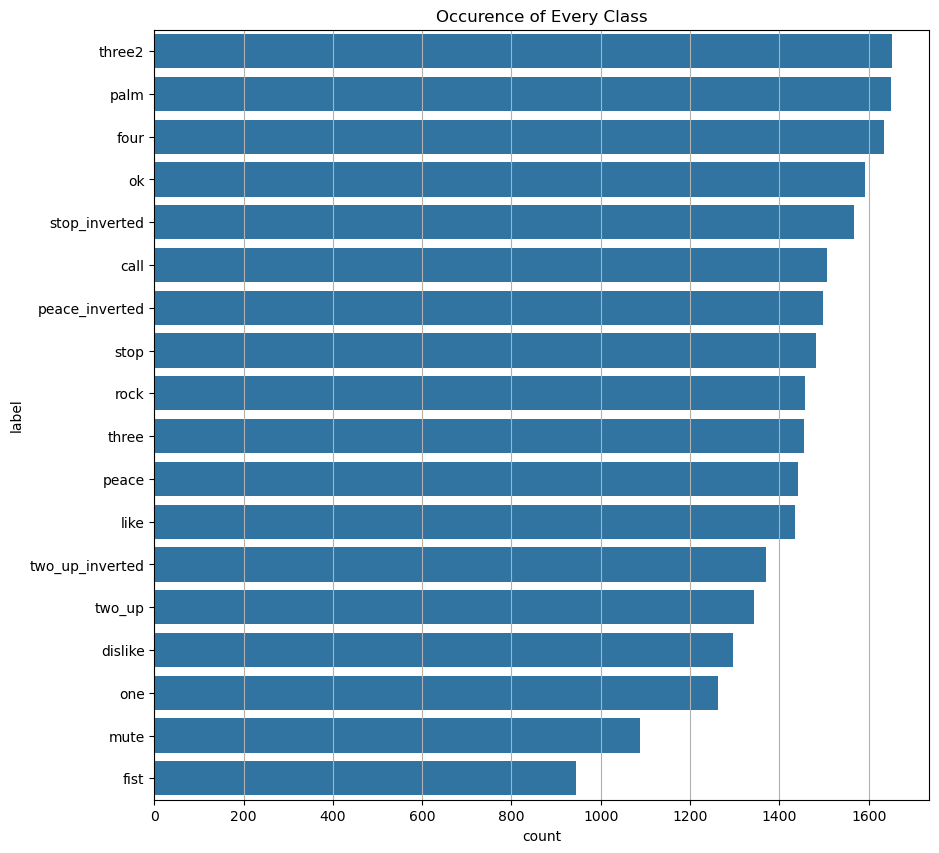

In [6]:
plt.figure(figsize=(10,10))
labels_sorted = df.label.value_counts()
sns.barplot(labels_sorted, orient='h')
plt.grid(axis = 'x')
plt.title("Occurence of Every Class")
plt.show()


#### What is the distribution of each column?

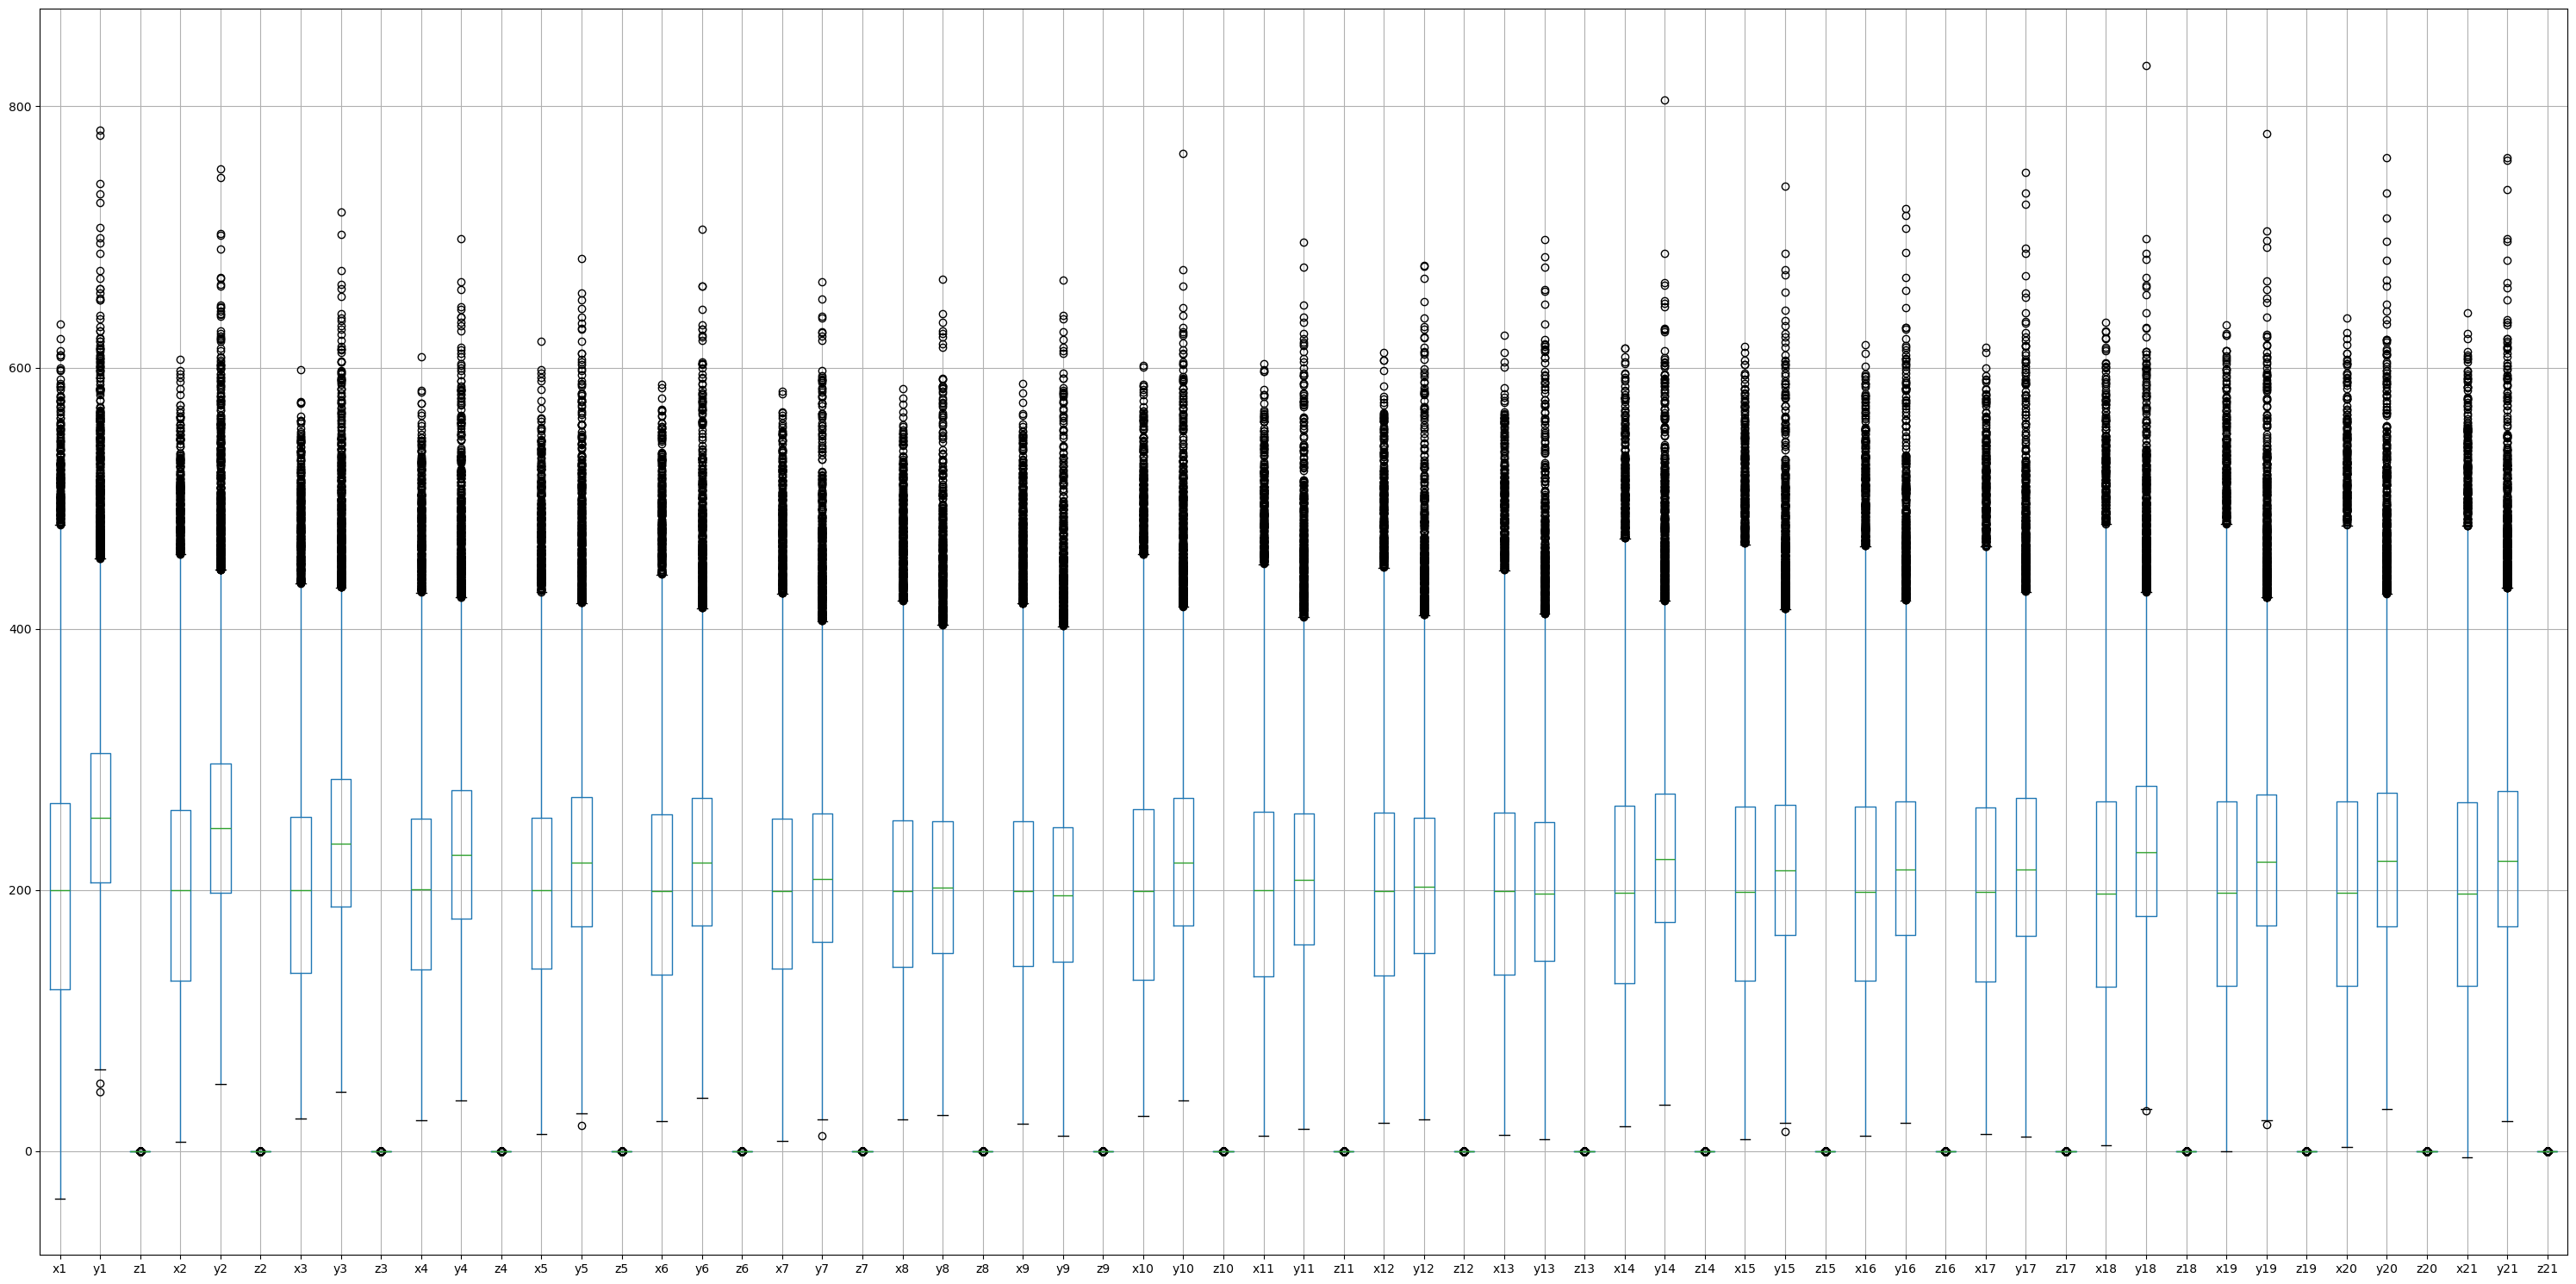

In [7]:
df.boxplot(figsize=(30,15))
plt.tight_layout()
plt.show()

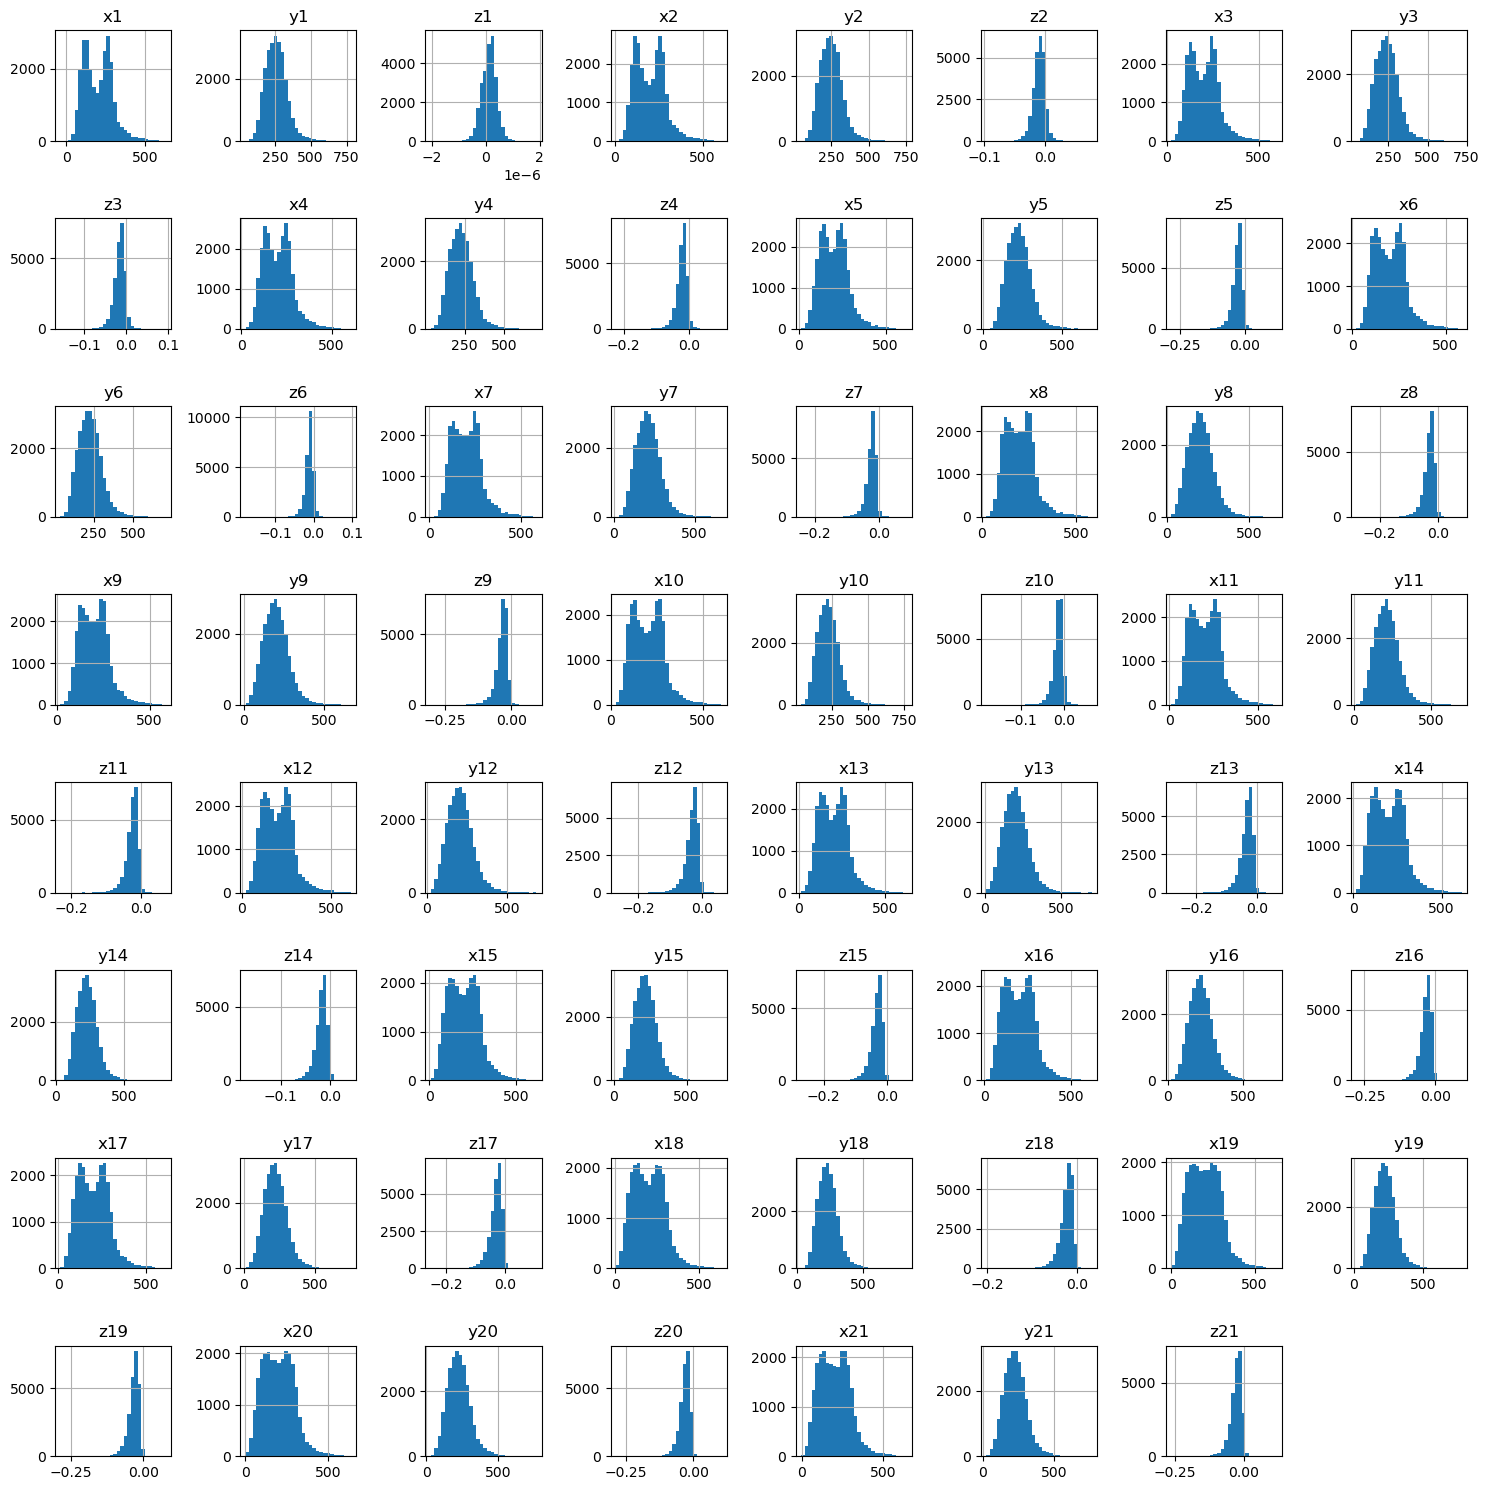

In [8]:
df.hist(figsize=(15,15), bins=30)
plt.tight_layout()
plt.show()

We can notice that most of the data follows the same shape but the X, Y variables have very big scale compared with the Z variables. We will deal with this later.

In [9]:
dic = {}
for label in df.label.unique():
    dic[label] = {
        'x': df[df['label'] == label].iloc[0][:-1:3].values,
        'y': df[df['label'] == label].iloc[0][1:-1:3].values,
        'z': df[df['label'] == label].iloc[0][2:-1:3].values
    }


In [10]:

for key, value in dic.items():    
    fig = px.scatter_3d(**value, title=key)
    fig.show()
    


## Data Preprocessing

From the histogram above we see that there is difference in scaling between variables:
* X, Y variables values range between 0 and 500.
* Z variable value range from -1 to 1

So We need to normalize the values of X and Y.

We can normalize hand landmarks to make the origin the **wrist point (x0, y0)** by subtracting all the points by it. Then dividing all landmarks by the **mid-finger tip point (y12)**.


In [11]:
def normalize_hand(x: pd.Series, with_label=True) -> pd.Series:
    """takes a row and returns a normalized row with $(x_i, y_i) = [(x_i - x_0, y_i - y_0)]$ 
    then dividing them by y12 $(x_i, y_i) = (x_i/y_12, y_i/y_12)

    Arguments:
        x           -- row as a pd.series with data of 21 point + label
        with_label  -- Bolean value indicating whether to return the label or not

    Returns:
        hand marks normalized 
    """
    xs = (x[0:-1:3] - x.iloc[0])
    ys = (x[1:-1:3] - x.iloc[1])
    xs = xs/ys.iloc[12]
    ys = ys/ys.iloc[12]
    zs =  x[2:-1:3]
    
    if with_label:
        label = x[-1:-2:-1]
        result = pd.concat([xs, ys, zs, label])
    
    else:
        result = pd.concat([xs, ys, zs])
   
    return result
    
    

In [12]:
centered_df = df.apply(normalize_hand, axis=1)
centered_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z13,z14,z15,z16,z17,z18,z19,z20,z21,label
0,0.0,-0.661176,-1.987272,-3.308815,-4.102851,-3.089077,-4.659729,-4.608856,-4.344135,-3.246133,...,-0.016854,-0.009528,-0.016194,-0.020701,-0.023142,-0.013198,-0.020450,-0.024577,-0.026722,call
1,-0.0,0.084779,-0.399809,-0.730293,-0.660683,-1.485415,-2.571265,-2.203642,-1.792421,-1.741628,...,-0.036610,-0.026222,-0.034942,-0.030081,-0.027561,-0.029042,-0.038175,-0.037336,-0.036136,call
2,-0.0,-1.234568,-3.125451,-4.432215,-4.329529,-6.313719,-9.236252,-8.276902,-7.094139,-6.702816,...,-0.027500,-0.033584,-0.038898,-0.033344,-0.030234,-0.041256,-0.044068,-0.040469,-0.038301,call
3,-0.0,0.037767,-0.132481,-0.216158,-0.142855,-1.181229,-1.968069,-1.709612,-1.348597,-1.435514,...,-0.021387,-0.017837,-0.021707,-0.018406,-0.017291,-0.021804,-0.027622,-0.027863,-0.027723,call
4,-0.0,0.016587,-0.192702,-0.227138,0.033596,-0.848297,-1.849583,-1.628523,-1.295793,-1.060627,...,-0.023731,-0.018826,-0.023907,-0.020978,-0.019323,-0.021623,-0.025113,-0.024087,-0.023486,call


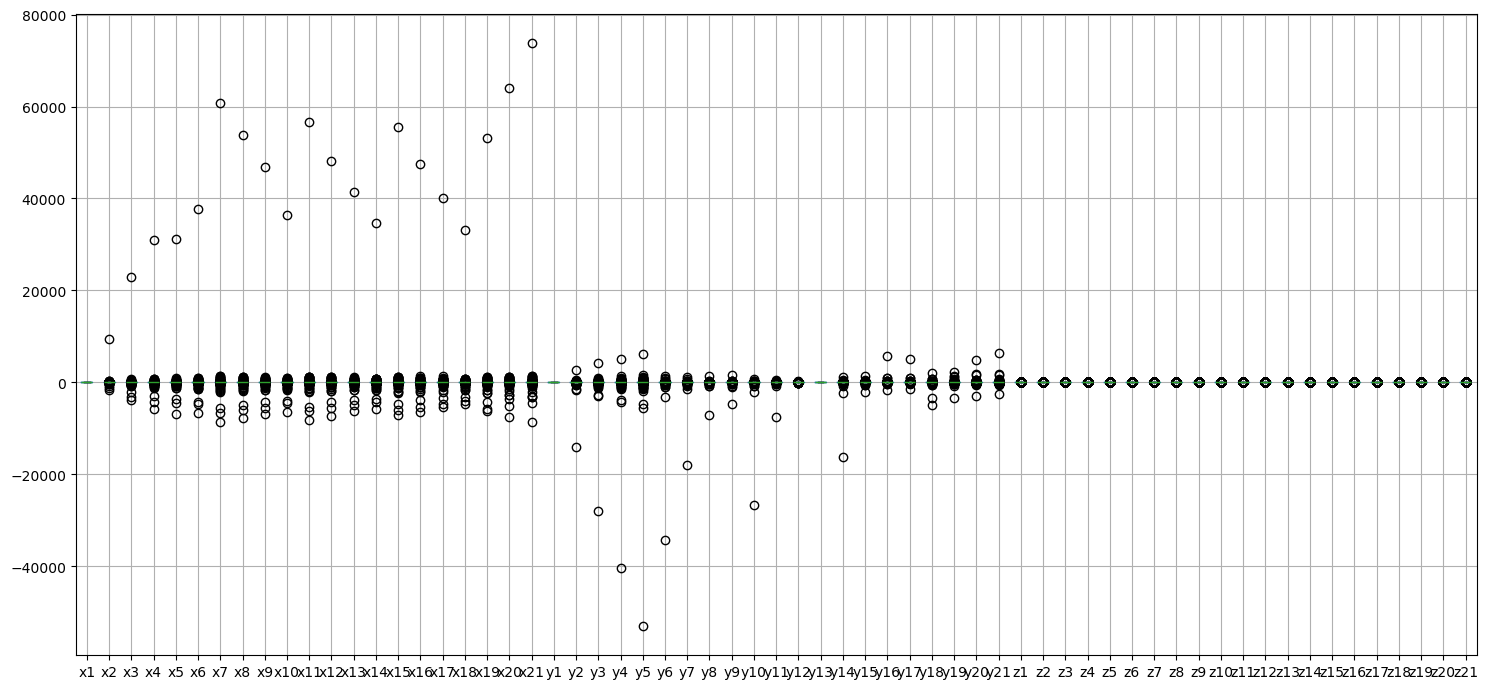

In [13]:
centered_df.boxplot(figsize=(15,7))
plt.tight_layout()
plt.show()

In [ ]:

X = centered_df.drop('label', axis = 1).values
y = centered_df['label'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

joblib.dump(label_encoder, '../exports/encoder.pkl')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test, random_state=42 )


In [15]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 20540 samples
Validation set size: 2568 samples
Test set size: 2567 samples


## Model Training

In [16]:
def evaluate(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    acc_train = model.score(X_train, y_train)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')

    y_val_pred = model.predict(X_val)
    acc_val = model.score(X_val, y_val)
    f1_val = f1_score(y_val, y_val_pred, average='weighted')

    print('== Train ==')
    print(f'Train accuracy: {acc_train}\nTrain f1: {f1_train}')

    print('== Validation ==')
    print(f'Validation accuracy: {acc_val}\nValidation f1: {f1_val}')

###  KNN

In [17]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

evaluate(knn,X_train, y_train, X_val, y_val)

== Train ==
Train accuracy: 1.0
Train f1: 1.0
== Validation ==
Validation accuracy: 0.9633956386292835
Validation f1: 0.963309385628456


### Random Forests

In [18]:
rforest = RandomForestClassifier(n_estimators=250 ,n_jobs=-1)
rforest.fit(X_train, y_train)

evaluate(rforest, X_train, y_train, X_val, y_val)

== Train ==
Train accuracy: 1.0
Train f1: 1.0
== Validation ==
Validation accuracy: 0.971183800623053
Validation f1: 0.9711827393876219


### Support Vector Machines 

In [19]:
support = SVC(kernel='rbf', C=350, gamma='auto', probability=True)
support.fit(X_train, y_train)

evaluate(support, X_train, y_train, X_val, y_val)

== Train ==
Train accuracy: 0.9888023369036028
Train f1: 0.988811961112966
== Validation ==
Validation accuracy: 0.9723520249221184
Validation f1: 0.972342784497747


### XGBoosting

In [20]:
xgb = XGBClassifier(n_estimators=150, learning_rate=0.2, n_jobs=-1)
xgb.fit(X_train, y_train)

evaluate(xgb, X_train, y_train, X_val, y_val)

== Train ==
Train accuracy: 1.0
Train f1: 1.0
== Validation ==
Validation accuracy: 0.9805295950155763
Validation f1: 0.9805644098933589


### LGBM

In [21]:
light = LGBMClassifier(num_leaves=64, n_estimators=300, n_jobs=-1, verbose=-1, random_state=42)
light.fit(X_train, y_train)

evaluate(light, X_train, y_train, X_val, y_val)

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



== Train ==
Train accuracy: 1.0
Train f1: 1.0
== Validation ==
Validation accuracy: 0.9813084112149533
Validation f1: 0.9813558812617974


In [ ]:
voting_clf = VotingClassifier(
    estimators=[('light', light), ('xgb', xgb), ('knn', knn), ('svc', support)],
    voting = 'soft',
    n_jobs = -1
)
voting_clf.fit(X_train, y_train)

evaluate(voting_clf, X_train, y_train, X_val, y_val)

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



== Train ==
Train accuracy: 1.0
Train f1: 1.0
== Validation ==
Validation accuracy: 0.9832554517133957
Validation f1: 0.9832921790425081


In [23]:

stacking_clf = StackingClassifier(
    estimators=[('light', light), ('xgb', xgb), ('knn', knn), ('svc', support)],
    final_estimator=LogisticRegression(n_jobs=-1,warm_start=True),
)

stacking_clf.fit(X_train, y_train)
evaluate(stacking_clf, X_train, y_train, X_val, y_val)

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature na

== Train ==
Train accuracy: 0.9997078870496592
Train f1: 0.9997079264819028
== Validation ==
Validation accuracy: 0.9855919003115264
Validation f1: 0.9856051361724536


## Evaluation

In [24]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model on test set and display results
    """

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)
    
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    return {'accuracy': accuracy, 'f1_score': f1, 'classification_report': report}



Evaluating final model on test set...


/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Test Accuracy: 0.9868
Test F1 Score: 0.9868
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.98      0.99      0.98       130
           2       1.00      0.99      0.99        95
           3       0.98      0.98      0.98       163
           4       0.99      0.97      0.98       143
           5       0.99      0.96      0.98       109
           6       1.00      0.99      1.00       159
           7       0.95      0.98      0.96       127
           8       0.99      0.99      0.99       165
           9       0.99      0.99      0.99       144
          10       1.00      0.99      1.00       149
          11       1.00      0.99      1.00       146
          12       0.97      0.98      0.97       148
          13       0.99      0.99      0.99       157
          14       1.00      0.99      1.00       145
          15       0.99      0.99      0.99       165
          16  

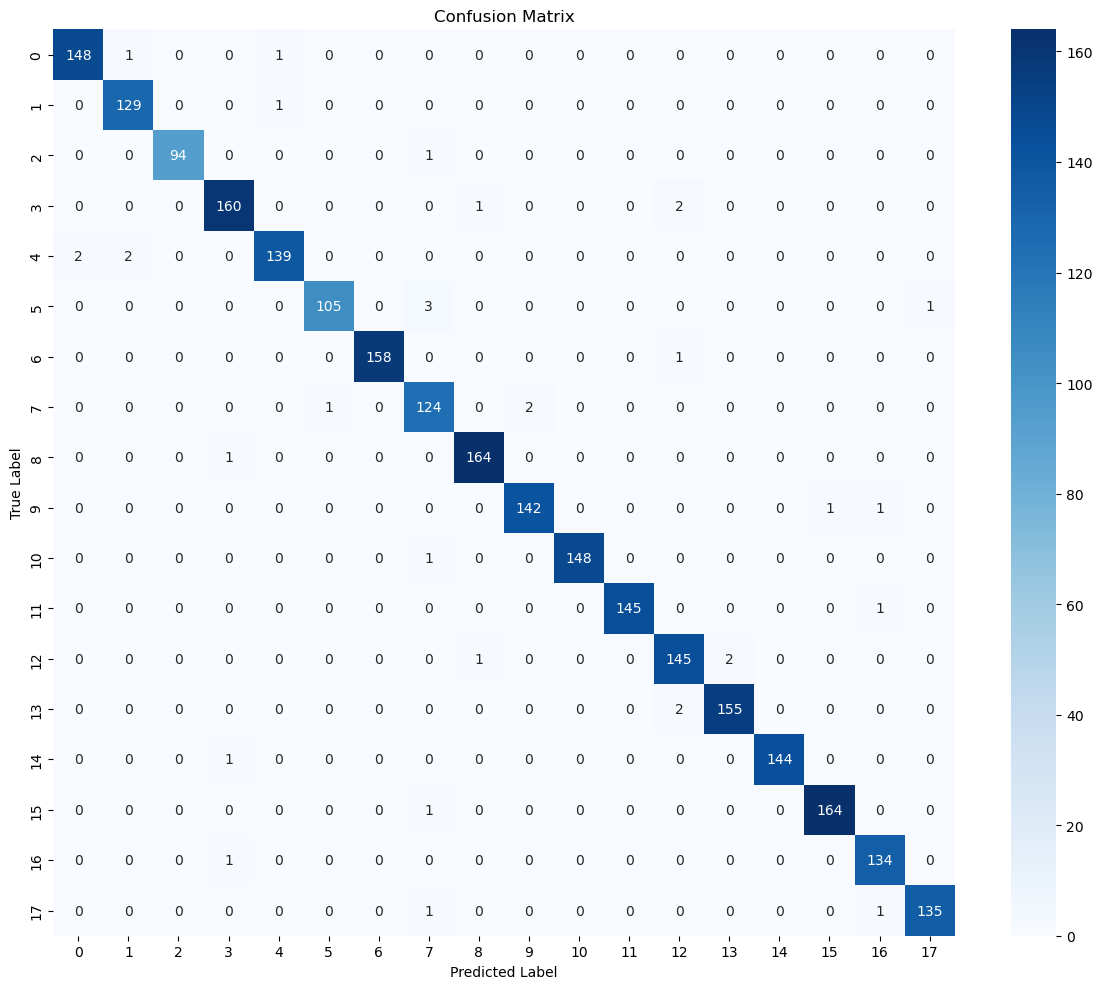

In [25]:
# Final evaluation on test set
print("\nEvaluating final model on test set...")
test_results = evaluate_model(stacking_clf, X_test, y_test)


In [31]:
# Fitting on all data
stacking_clf.fit(X, y)

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature na

StackingClassifier(estimators=[('light',
                                LGBMClassifier(n_estimators=300, n_jobs=-1,
                                               num_leaves=64, random_state=42,
                                               verbose=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_type...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=150, n_jobs=-1,
                                              num_parallel_tree=None, ...)),
                               ('knn',
                                KNeighborsClassifier(n_jobs=-1,
                                                     weights='distance')),
                               ('svc',
                                SVC(C=350, gamma='auto', probability=True))],
                   final_estimator=LogisticRegression(n_jobs=-1,
                                                      warm_start=True))

In [ ]:
joblib.dump(stacking_clf, f'../exports/hand_gesture_final_model.pkl')
print(f"\nFinal model saved as 'hand_gesture_final_model.pkl'")


Final model saved as 'hand_gesture_final_model.pkl'


## Conclusion

We have structured numerical tabular data which is easy to be fitted with a lot of good models. But first we needed to normalize our data to help with making the classification more accurate and consistent with different postures during inference. After doing that successfully, It was an easy task to cherry pick the best perofrmant model. since almost all models can fit the data pretty well, We opted to choose an ensemble of them all to get the best of them all. Which resulted in getting a **98.56%** on the validation set using a stacking classifier of **LGBMVlassifier**, **XGBClassifier**, **KNNClassifier**, **SVC**, and blending them using a **LogisticRegression**.

After testing the model on our test set which resulted in **99% score** on both **f1-score** and the **accuracy** score we decided to train the model on all of our data before using it on the real world classification. 
